In [11]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import DensityMatrix, Operator,Statevector
import matplotlib.pyplot as plt

"""Generate the pure state |T₀⟩ via a Y-rotation followed by a phase shift.

   |T₀⟩ = cos(β)|0⟩ + e^{iπ/4} sin(β)|1⟩
"""

# Define β
beta = 0.5 * np.arccos(1.0 / np.sqrt(3))

# Construct the state vector: cos(β)|0⟩ + e^{iπ/4} sin(β)|1⟩
amp0 = np.cos(beta)
amp1 = np.exp(1j * np.pi / 4) * np.sin(beta)
state = np.array([amp0, amp1], dtype=complex)

# Generate the density matrix ρ = |ψ⟩⟨ψ|
rho = np.outer(state, state.conjugate())

rho_5 = np.kron(np.kron(np.kron(np.kron(rho, rho), rho), rho), rho)



def magic_state_noisy_density_matrix(rho, q):
    """
    Build the single-qubit noisy magic state (here a T-state) under
    depolarizing rate q:  C₁ = (1-q)·A + q·B₁.

    Parameters
    ----------
    rho : ndarray, shape (2, 2)
        Density matrix of a single-qubit pure magic state.
    q   : float
        Depolarizing rate, 0≤q≤1.

    Returns
    -------
    C₁ : ndarray, shape (2, 2)
        Noisy single-qubit magic-state density matrix.
    """
    # 1. Density matrix of the T‑state, A = |T⟩⟨T|
    A = rho

    # 2. Single‑qubit maximally mixed state, B₁ = I/2
    B_1 = np.eye(2, dtype=complex) / 2

    # 3. C₁ = (1‑q)·A + q·B₁
    C_1 = (1 - q) * A + q * B_1

    return C_1


def build_m_qubit_magic_depol(rho, q):
    """
    Build the m‑qubit “correlated” noisy magic state

        C_m = (1‑q)(A⊗m) + q·B_m.

    Here m = 5 is hard‑coded.

    Parameters
    ----------
    rho : ndarray, shape (2, 2)
        Single-qubit density matrix (e.g. the magic state).
    q   : float
        Depolarizing rate, 0≤q≤1.

    Returns
    -------
    C₅ : ndarray, shape (2⁵, 2⁵)
        Five-qubit noisy magic-state density matrix.
    """
    # 1. Tensor product A⊗5
    bigA = rho
    for _ in range(4):
        bigA = np.kron(bigA, rho)

    # 2. Five‑qubit maximally mixed state, B₅ = I/32
    dim = 2 ** 5
    B_5 = np.eye(dim, dtype=complex) / dim

    # 3. Linear combination
    C_5 = (1 - q) * bigA + q * B_5

    return C_5


def build_rhoin(r, q):
    """
    Construct  rho_in = (1-r)(C₁⊗5) + r·C₅.

    Parameters
    ----------
    r, q : float
        r, q ∈ [0,1];  r mixes between product and correlated noise,
        q is the depolarizing rate.

    Returns
    -------
    rho_in : ndarray, shape (32, 32)
        The final five-qubit input density matrix.
    """
    # 1. Single‑qubit noisy magic state C₁
    C_1 = magic_state_noisy_density_matrix(rho, q)

    # 2. Tensor product C₁⊗5
    C_1_5 = C_1
    for _ in range(4):
        C_1_5 = np.kron(C_1_5, C_1)

    # 3. Five‑qubit correlated noisy magic state C₅
    C_5 = build_m_qubit_magic_depol(rho, q)

    # 4. Linear combination
    rho_in = (1 - r) * C_1_5 + r * C_5
    return rho_in


def compute_one_minus_trace(A, D):
    """
    Compute  1-Tr(A·D).

    Parameters
    ----------
    A, D : ndarray
        Square matrices of the same shape.

    Returns
    -------
    result : complex or float
        The value 1-Tr(A·D).
    """
    if A.shape != D.shape:
        raise ValueError("A and D must have the same shape.")

    trace_AD = np.trace(A @ D)
    return 1 - trace_AD


def first_qubit_conditional_state(r):
    """
    Given a 5-qubit 32×32 density matrix ρ, output the 2×2 post‑measurement
    state of qubit 1 conditioned on measuring qubits 2–5 in |0⟩.

    Parameters
    ----------
    r : ndarray, shape (32, 32)
        Five-qubit density matrix.

    Returns
    -------
    r_out : ndarray, shape (2, 2)
        Posterior single-qubit state of qubit 1.
    """
    if r.shape != (32, 32):
        raise ValueError("ρ must be 32×32 (a 5‑qubit state).")

    # ------------------------------------------------------------------
    # 1. Basis vectors |0 0000⟩ and |1 0000⟩ (binary 00000 → 0, 10000 → 16)
    # ------------------------------------------------------------------
    e0 = np.zeros(32, dtype=complex)
    e0[0] = 1.0
    e1 = np.zeros(32, dtype=complex)
    e1[16] = 1.0

    # Projectors
    A1 = np.outer(e0, e0.conjugate())  # |0 0000⟩⟨0 0000|
    A2 = np.outer(e1, e1.conjugate())  # |1 0000⟩⟨1 0000|
    A3 = np.outer(e1, e0.conjugate())  # |1 0000⟩⟨0 0000|
    A4 = np.outer(e0, e1.conjugate())  # |0 0000⟩⟨1 0000|

    # Expectation values → 2×2 matrix
    M11 = np.trace(r @ A1)
    M22 = np.trace(r @ A2)
    M12 = np.trace(r @ A3)
    M21 = np.trace(r @ A4)

    M = np.array([[M11, M12],
                  [M21, M22]], dtype=complex)

    # Normalize
    p = M11 + M22
    if abs(p) < 1e-15:
        return np.zeros((2, 2), dtype=complex)
    return M / p


def partial_trace_first_qubit(r):
    """
    Trace out qubits 2–5 of a 5‑qubit state ρ₅ (32×32) and return the
    reduced state ρ₁ (2×2) of qubit 1.

    Parameters
    ----------
    r : ndarray, shape (32, 32)
        Five‑qubit density matrix.

    Returns
    -------
    rho_1 : ndarray, shape (2, 2)
        Reduced density matrix of qubit 1.
    """
    if r.shape != (32, 32):
        raise ValueError("ρ₅ must be 32×32 (a 5‑qubit system).")

    dim_sub   = 2          # Dimension of the kept qubit
    dim_trace = 16         # Dimension of the traced‑out subsystem (2⁴)

    rho_1 = np.zeros((dim_sub, dim_sub), dtype=complex)

    # Sum over the traced subsystem indices
    for i in range(dim_sub):
        for j in range(dim_sub):
            elem = 0.0 + 0.0j
            for a in range(dim_trace):
                row = i * dim_trace + a
                col = j * dim_trace + a
                elem += r[row, col]
            rho_1[i, j] = elem

    return rho_1

from qiskit import QuantumCircuit

def error_correction_decoder(wires):
    """Error correction decoder for the 5-qubit error correction code generated by stabilizers XZZXI, IXZZX, XIXZZ, ZXIXZ.
    """
    # Create a quantum circuit
    circuit = QuantumCircuit(5)  # 5 qubits

    # Unpack the wire indices for convenience
    w0, w1, w2, w3, w4 = wires

    # Implement controlled gates
    circuit.cx(w1, w0)  # CNOT(wires=[w1, w0])
    circuit.cz(w1, w0)  # CZ(wires=[w1, w0])
    circuit.cz(w1, w2)  # CZ(wires=[w1, w2])
    circuit.cz(w1, w4)  # CZ(wires=[w1, w4])

    circuit.cx(w2, w0)  # CNOT(wires=[w2, w0])
    circuit.cz(w2, w3)  # CZ(wires=[w2, w3])
    circuit.cz(w2, w4)  # CZ(wires=[w2, w4])

    circuit.cx(w3, w0)  # CNOT(wires=[w3, w0])

    circuit.cx(w4, w0)  # CNOT(wires=[w4, w0])
    circuit.cz(w4, w0)  # CZ(wires=[w4, w0])

    # Apply Pauli‑Z gates
    circuit.z(w0)  # PauliZ(wires=w0)
    circuit.z(w1)  # PauliZ(wires=w1)
    circuit.z(w4)  # PauliZ(wires=w4)

    # Apply Hadamard gates
    circuit.h(w1)  # Hadamard(wires=w1)
    circuit.h(w2)  # Hadamard(wires=w2)
    circuit.h(w3)  # Hadamard(wires=w3)
    circuit.h(w4)  # Hadamard(wires=w4)
    circuit.h(w0)  # Hadamard(wires=w0)
    circuit.y(w0)  # PauliY(wires=w0)
    return circuit

# Example: create a quantum circuit and apply the error‑correction decoder
wires = [4, 3, 2, 1, 0]  # Qubit indices
decoder_circuit = error_correction_decoder(wires)

# Draw the quantum circuit
decoder_circuit.draw('mpl')


def distill_and_compute_e(rho_in, decoder_circuit):
    """
    Using the provided decoder_circuit, build the unitary operator U,
    apply the transformation U · ρ₅ · U† (i.e., the distillation step) to the
    5‑qubit density matrix, then compute the single‑qubit conditional state and
    return the error metric e.

    Parameters
    ----------
    rho_5 : ndarray, shape (32, 32)
        Five‑qubit density matrix.
    decoder_circuit : qiskit.QuantumCircuit
        Quantum circuit that generates the unitary U.

    Returns
    -------
    e : float
        Result of compute_one_minus_trace(...).
    """

    # 1) Obtain the unitary matrix U from the circuit
    U = Operator.from_circuit(decoder_circuit).data

    # 2) Conjugate transpose U†
    U_dagger = np.conjugate(np.transpose(U))

    # 3) Distilled state: ρ' = U ρ U†
    result = U @ rho_in @ U_dagger

    # 4) Conditional subsystem of the first qubit
    rho1 = first_qubit_conditional_state(result)

    # 5) Compute the error metric e
    #    Note: the original example called compute_one_minus_trace(rho, rho1);
    #    here we assume rho refers to the five‑qubit state.
    e = compute_one_minus_trace(rho, rho1)

    return e

# Set font properties globally
plt.rcParams['font.family'] = 'Times New Roman'  # Set font family

def plot_magic_state_error_vs_r(decoder_circuit):
    """
    Plot the error rates of the magic state before and after distillation
    as r varies from 0 to 1 for different depolarizing rates q, using a logarithmic
    scale for the y-axis.

    Parameters
    ----------
    decoder_circuit : Qiskit.QuantumCircuit
        User-defined 5-qubit distillation circuit to obtain the unitary U.
    """
    # 1) Set the values for r and q
    r_values = np.linspace(0, 1, 1000)          # For example, evenly sample r from 0 to 1 with 1000 points
    q_values = [0.1, 0.01, 0.001]                # Several q values to compare

    plt.figure(figsize=(8, 6))

    # 2) Iterate over different q values, plotting both curves “before distillation (e_pre)”
    #    and “after distillation (e_post)”
    for q in q_values:
        e_pre_list = []
        e_post_list = []
        for r in r_values:
            # a) Construct the input state rho_in
            rho_in = build_rhoin(r, q)

            # b) Compute the error rate before distillation e_pre
            #    where rho1 = first_qubit_conditional_state(rho_in)
            rho1 = partial_trace_first_qubit(rho_in)
            e_pre = compute_one_minus_trace(rho, rho1)
            e_pre_list.append(e_pre)

            # c) Compute the error rate after distillation e_post
            e_post = distill_and_compute_e(rho_in, decoder_circuit)
            e_post_list.append(e_post)

        # d) Plot the curves on a logarithmic scale
        #    Different line styles distinguish before/after distillation,
        #    while the same color indicates the same q.
        #plt.semilogy(r_values, e_pre_list, '--', label=f"pre, q={q}")
        plt.semilogy(r_values, e_post_list, '-', label=f"q={q}")

    # 3) Beautify the plot
    plt.xlabel('Fraction of global depolarising, r', fontsize=12)
    plt.ylabel('Error rate of output magic states', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_magic_state_error_vs_q(decoder_circuit):
    """
    Fix several r values and scan 0 < q ≤ 1,
    plot the error rates e before and after distillation of magic states,
    using a logarithmic scale for both axes (log-log plot).
    """
    
    # 1) Fix r and scan q
    r_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]          # Several r values of interest
    q_values = np.logspace(-4, -2, 400)              # 10⁻⁶ ~ 1, with 400 points (cannot include 0)

    plt.figure(figsize=(8, 6))

    # 2) For each r, plot two curves before and after distillation
    for r in r_values:
        e_post_list = []

        for q in q_values:
            # a) Construct the input state ρ_in
            rho_in = build_rhoin(r, q)

            # c) Compute the error rate after distillation e_post
            e_post = distill_and_compute_e(rho_in, decoder_circuit)
            e_post_list.append(e_post)

        # d) Plot using log-log coordinates
        plt.loglog(q_values, e_post_list, '-', label=f"r={r}")

    # 3) Beautify the plot
    plt.xlabel('Depolarizing noise strength in input magic states, q', fontsize=12)
    plt.ylabel('Error rate of output magic states', fontsize=12)
    #plt.title ('Magic‑state error vs q (log‑log)', fontsize=14)
    plt.legend()
    #plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.tight_layout()
    plt.show()




/Users/steven/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/steven/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


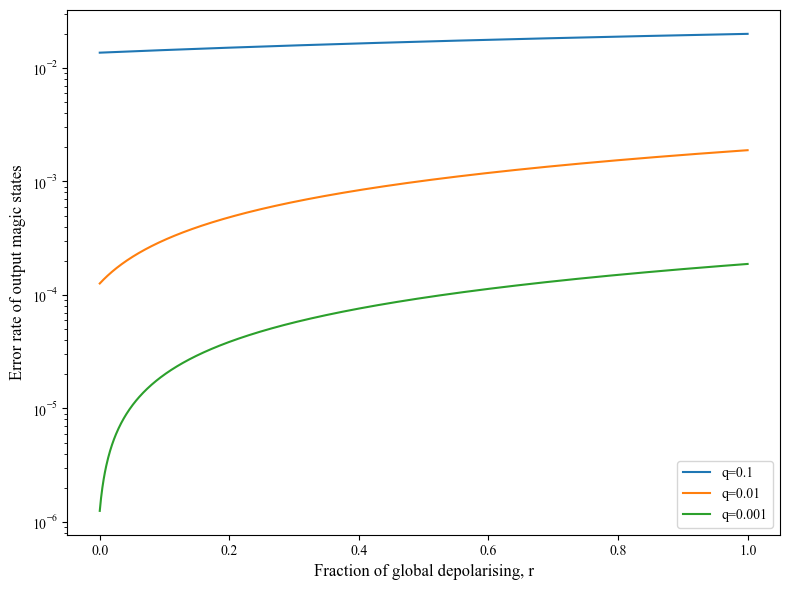

In [12]:
plot_magic_state_error_vs_r(decoder_circuit)

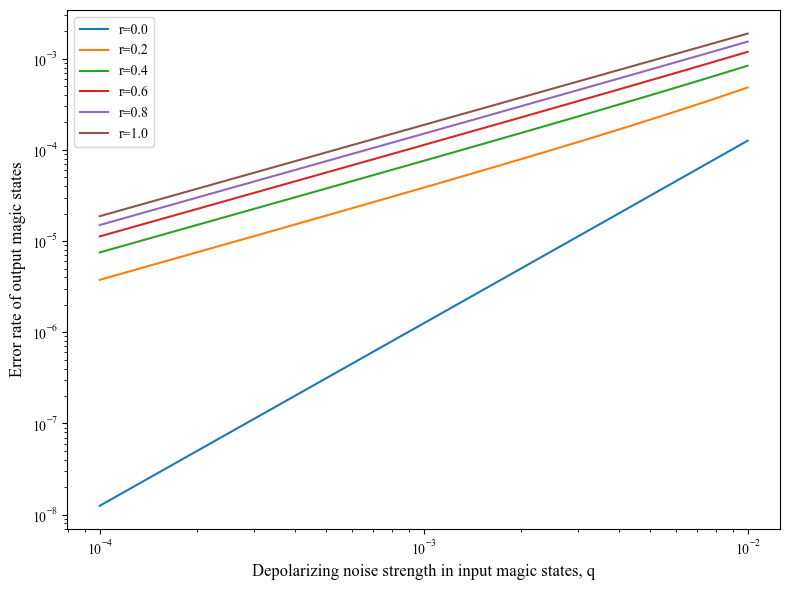

In [13]:
plot_magic_state_error_vs_q(decoder_circuit)